# WELCOME !!!!

## This mini project is done for the MS DS of the U of Colorado Boulder. In this project, we will take a look at using Deep learning to build a classifier. We will work with data, clean and format it, then we will use DistilBert to build our classifier ! :D       
## This notebook is split into 4 sections:
### PART 1: GETTING THE DATA AND READING IT
### PART 2: VISUALISING THE DATA AND PERFORMING SOME EDA
### PART 3: PREPROCESSING THE DATA SO THAT IT CAN BE USED IN OUR MODEL
### PART 4: BUILDING AND VALIDATING OUR MODEL

In [1]:
import tensorflow as tf
import os
try:
    import ktrain
except:
    !pip install ktrain
    import ktrain
from ktrain import text
from ktrain.text import texts_from_df
from keras.preprocessing.text import Tokenizer
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random
import nltk
from nltk import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('omw-1.4')
from string import punctuation, digits
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud
import itertools
import warnings
warnings.filterwarnings('ignore')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.3/25.3 MB 35.1 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 49.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 263.7/263.7 kB 18.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 67.6 MB/s eta 0:00:00:00:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.8/468.8 kB 32.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for ktrain: filename=ktrain-0.31.10-py3-none-any.whl size=25312982 sha256=43581cdd320b847f22ce8736e4c081893c29996b60822a77550e235c1f4617b2
  Stored in dire

[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...


# PART 1: THE DATA

### Getting and reading the data using pandas

In [2]:
train_data = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
test_data = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")
sample_submission = pd.read_csv("/kaggle/input/nlp-getting-started/sample_submission.csv")

In [3]:
train_data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
test_data.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [5]:
train_data.shape

(7613, 5)

In [6]:
test_data.shape

(3263, 4)

### From this simple analysis, we can see that we have 7500 texts in our training data, and 3200 in our validation set. We also have some columns that we will be dropping since they are not useful for predicting if a text is about a disaster or not.

In [7]:
train_data.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [8]:
test_data.isnull().sum()

id             0
keyword       26
location    1105
text           0
dtype: int64

In [9]:
sample_submission.head()

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


In [10]:
train_data.loc[0]['text']

'Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all'

In [11]:
test_data.loc[0]["text"]

'Just happened a terrible car crash'

# PART 2: VISUALIZING THE DATA AND EDA

### Just by looking at some samples in the train_data, we can deduce that a 1 indicates a Disaster, and a 0 no disasters

In [12]:
train_data

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


In [13]:
train_data['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

([<matplotlib.patches.Wedge at 0x7f0771de51d0>,
 [Text(-0.24110481617711207, 1.0732513534192263, 'No Disaster'),
  Text(0.24110481617711216, -1.0732513534192263, 'Disaster')],
 [Text(-0.13151171791478838, 0.5854098291377597, '57.034%'),
  Text(0.13151171791478844, -0.5854098291377597, '42.966%')])

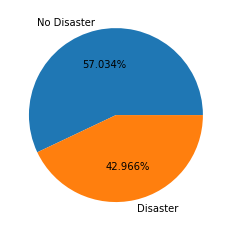

In [14]:
plt.pie(train_data['target'].value_counts(), 
        labels=["No Disaster","Disaster"],
       autopct="%.3f%%")

<BarContainer object of 2 artists>

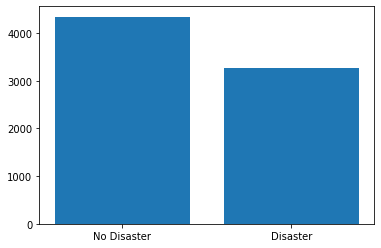

In [15]:
plt.bar(x=["No Disaster", "Disaster"], 
        height=train_data['target'].value_counts())

### We can see that we have a roughly balanced dataset, so we don't really need to do any big data manipulation. We have about 40% of the texts that speak about a disaster, and 60% that don't mention a disaster. We will see later how to balance this data so that we have an even number of disaster and non disaster text.       
### Now, we need to clean the data by getting read of the stopwords that are commonly used in english, as well as tokenizing and lemmatizing our texts.

# PART 3: CLEANING THE DATA

In [16]:
def clean_text(data):
    """
    input: data: a dataframe containing texts to be cleaned
    return: the same dataframe with an added column of clean text
    """
    data['clean_text'] = data['text'].str.lower()
    stop_words = list(stopwords.words('english'))
    punctuations = list(punctuation)
    clean_text = []
    lemmatizer = WordNetLemmatizer()
    for idx, row in enumerate(data['clean_text']):
        split_text = row.split()
        clean_text = [lemmatizer.lemmatize(word) for word in split_text if word not in stop_words and word not in punctuation]
        
        clean_text = ' '.join(clean_text)
        data.loc[idx]['clean_text'] = clean_text
    return data

### The above function does the following: it reads in a dataframe, and selects the 'text' column. It will lemmatize a word if the word is not a stopword or a punctuation. This is useful because otherwise we would have a lot of superfluous, and ultimately useless, data inside our training dataset. We then create a new Dataframe to avoid confusions with the trainining dataset. However, you may have noticed that we are keeping the # symbol. I decided to keep it because since we have twitter data, an hashtag may have some relevant information for our model.

In [17]:
clean_train_data = clean_text(train_data)

In [18]:
clean_train_data.head()

,id,keyword,location,text,target,clean_text
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,our deeds are the reason of this #earthquake m...
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask. canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,all residents asked to 'shelter in place' are ...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,"13,000 people receive #wildfires evacuation or..."
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,just got sent this photo from ruby #alaska as ...


### We can drop the 'text' column since we created a new one with the clean text in it, we can also drop the 'keyword' and 'location' column as well since we will classify based only on the contents of a text.

In [19]:
clean_train_data = clean_train_data.drop(['keyword', 'location', 'text'], 
                                         axis=1)

In [20]:
clean_train_data

,id,target,clean_text
0,1,1,our deeds are the reason of this #earthquake m...
1,4,1,forest fire near la ronge sask. canada
2,5,1,all residents asked to 'shelter in place' are ...
3,6,1,"13,000 people receive #wildfires evacuation or..."
4,7,1,just got sent this photo from ruby #alaska as ...
...,...,...,...
7608,10869,1,two giant cranes holding a bridge collapse int...
7609,10870,1,@aria_ahrary @thetawniest the out of control w...
7610,10871,1,m1.94 [01:04 utc]?5km s of volcano hawaii. htt...
7611,10872,1,police investigating after an e-bike collided ...


In [21]:
clean_train_data.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

### Since we don't have a fully balanced dataset, we are going to keep only 2500 samples from each category. 2500 for each category is enough to have a robust dataset, while still having a relatively short training and inference time.     
### We then merge each dataframe inside a new dataframe that we will use to build our model.

In [22]:
sample_amount = 2500

target = clean_train_data[clean_train_data['target']==1].sample(n=sample_amount)
non_target = clean_train_data[clean_train_data['target']==0].sample(n=sample_amount)

In [23]:
target.head()

,id,target,clean_text
4876,6943,1,@blairmcdougall and when will you be commentin...
2831,4072,1,.potus #strategicpatience is a strategy for #g...
2433,3495,1,sad that biker beatdown derailed his pro-democ...
4416,6277,1,the murderous story of americaûªs first hijac...
1241,1789,1,such beautiful architecture in #nyc i love tho...


In [24]:
non_target.head()

,id,target,clean_text
4792,6817,0,the chick i work with chews chewing gum so lou...
4985,7112,0,army names 10th mountain units for iraq afghan...
1178,1698,0,listening to blowers and tuffers on the aussie...
7564,10813,0,@__ohhmyjoshh @stevenrulles he not gonna be th...
7569,10819,0,@marynmck that's beyond adorable. i hope it wo...


In [25]:
data = pd.concat([target, non_target])
data.reset_index(inplace=True)
data.drop(['index', 'id'], axis=1, inplace=True)
data.head()

,target,clean_text
0,1,@blairmcdougall and when will you be commentin...
1,1,.potus #strategicpatience is a strategy for #g...
2,1,sad that biker beatdown derailed his pro-democ...
3,1,the murderous story of americaûªs first hijac...
4,1,such beautiful architecture in #nyc i love tho...


### We have our final dataset that we will use to train our model :D 

# PART 4: MODEL BUILDING AND EVALUATION

### I decided to use a Distilbert model for the following reasons: it's really easy to use and is well optimized, so the training time is quite fast. It is also easily explainable and has a few APIs that makes predictions easy to make and interpret, and finally the wrapper inside ktrain is really convenient. I woudl strongly encourage you to read this from the about Distilbert on the hugging face page: https://huggingface.co/docs/transformers/model_doc/distilbert

In [26]:
target_names = ['NOT DISASTER', 'DISASTER']

### We load the model, then do a train/test split. We choose the distilbert processing method

In [27]:
transformer = text.Transformer('distilbert-base-uncased', 
                              maxlen=512,
                              class_names=target_names)

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

### HYPERPARAMETERS: I've chosen to use 200 for the maxfeatures and a maxlen of 512 as it really speeds up the training process while not losing much in accuracy. We then call the model with a batch size of 16 to speed up even more the training process (a bigger batch size in this case led to a decrease in accuracy in the final model)

In [28]:
train, val, preprocess = texts_from_df(data, 'clean_text',
                                      label_columns=['target'],
                                      val_df=None,
                                      max_features=200,
                                      maxlen=512,
                                      val_pct=0.1,
                                      ngram_range=1,
                                      preprocess_mode='distilbert',
                                      verbose=1)

['not_target', 'target']
      not_target  target
4307         1.0     0.0
743          0.0     1.0
3072         1.0     0.0
1241         0.0     1.0
3265         1.0     0.0
['not_target', 'target']
      not_target  target
961          0.0     1.0
2208         0.0     1.0
2834         1.0     0.0
2274         0.0     1.0
4658         1.0     0.0
preprocessing train...
language: en
train sequence lengths:
	mean : 15
	95percentile : 24
	99percentile : 27


Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 15
	95percentile : 24
	99percentile : 27


In [29]:
model = preprocess.get_classifier()
learner = ktrain.get_learner(model, train_data=train,
                            val_data=val, batch_size=16) 

Downloading:   0%|          | 0.00/347M [00:00<?, ?B/s]

In [30]:
learner.lr_find(max_epochs=6)

simulating training for different learning rates... this may take a few moments...
Epoch 1/6
281/281 [==============================] - 257s 862ms/step - loss: 0.6886 - accuracy: 0.5429
Epoch 2/6
281/281 [==============================] - 249s 887ms/step - loss: 0.4981 - accuracy: 0.7788
Epoch 3/6
281/281 [==============================] - 248s 884ms/step - loss: 0.5359 - accuracy: 0.7288
Epoch 4/6
281/281 [==============================] - 247s 878ms/step - loss: 0.7082 - accuracy: 0.5040
Epoch 5/6
281/281 [==============================] - 242s 863ms/step - loss: 0.7041 - accuracy: 0.5054
Epoch 6/6
281/281 [==============================] - 199s 709ms/step - loss: 15576.1631 - accuracy: 0.4788


done.
Please invoke the Learner.lr_plot() method to visually inspect the loss plot to help identify the maximal learning rate associated with falling loss.


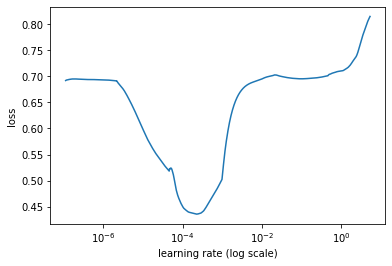

In [31]:
learner.lr_plot()

## early stopping here is used to stop the training if the performance drops, so as to gain time. We will only train the model for 6 epochs, as the goal of this mini project is not to build a full state-of-the art app, but rather just an introduction to NLP classification.

In [32]:
history=learner.autofit(1e-4,checkpoint_folder='checkpoint',epochs=11, 
                        early_stopping=True) 



begin training using triangular learning rate policy with max lr of 0.0001...
Epoch 1/11
282/282 [==============================] - 259s 891ms/step - loss: 0.4834 - accuracy: 0.7684 - val_loss: 0.3949 - val_accuracy: 0.8120
Epoch 2/11
282/282 [==============================] - 251s 886ms/step - loss: 0.3414 - accuracy: 0.8616 - val_loss: 0.4194 - val_accuracy: 0.8240
Restoring model weights from the end of the best epoch.
Epoch 00002: early stopping
Weights from best epoch have been loaded into model.


In [33]:
validation = learner.validate(val_data=val, print_report=True)

              precision    recall  f1-score   support

           0       0.74      0.87      0.80       217
           1       0.89      0.77      0.82       283

    accuracy                           0.81       500
   macro avg       0.81      0.82      0.81       500
weighted avg       0.82      0.81      0.81       500



## From the validation, we can see that we have really good metrics. Our accuracy and f1-score is 80%, which is great considering the relatively small dataset and training time !

## After training and validating our model, we get the predictions and create a frame that looks like the one provided.

In [34]:
predictor = ktrain.get_predictor(learner.model, preproc=preprocess)

In [35]:
test_data['target'] = 0

In [36]:
for i in range(len(test_data)):
    text = test_data.loc[i]['text']
    probs = predictor.predict(text, return_proba = True)
    if probs[0] >= 0.5:
        test_data.loc[i,'target'] = 0
    else:
        test_data.loc[i,'target'] = 1

In [37]:
test_data

,id,keyword,location,text,target
0,0,NaN,NaN,Just happened a terrible car crash,0
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",1
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",1
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,1
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,1
...,...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...,1
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...,1
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...,1
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...,1


In [38]:
test_data.drop(['keyword', 'location'],axis=1, inplace=True)

In [39]:
test_data

,id,text,target
0,0,Just happened a terrible car crash,0
1,2,"Heard about #earthquake is different cities, s...",1
2,3,"there is a forest fire at spot pond, geese are...",1
3,9,Apocalypse lighting. #Spokane #wildfires,1
4,11,Typhoon Soudelor kills 28 in China and Taiwan,1
...,...,...,...
3258,10861,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...,1
3259,10865,Storm in RI worse than last hurricane. My city...,1
3260,10868,Green Line derailment in Chicago http://t.co/U...,1
3261,10874,MEG issues Hazardous Weather Outlook (HWO) htt...,1


# CONCLUSION

## We can clearly see from the submission dataframe we have that we have done some good predictions. When submitting this, we have a score of 80, which is really good when we take into account the short training time and relatively small dataset we have. We could further improve this project by comparing between different DL architectures, or building our own NN. 
# Thank you for reading this!

In [40]:
submission_df = test_data.copy()

In [41]:
submission_df.drop('text', axis=1, inplace=True)

In [42]:
submission_df.head()

,id,target
0,0,0
1,2,1
2,3,1
3,9,1
4,11,1


In [43]:
submission_df.to_csv('submission.csv', index=False)